# <span style="color:green"> Monoasset test: Interpolation of market data </span>

In [23]:
from pricing import EquityForwardCurve, DiscountingCurve, Black, ForwardVariance, Vanilla_PayOff, ACT_365
import numpy as np
import matplotlib.pyplot as plt
from numpy import log, sqrt, exp
from montecarlo import MC
import lets_be_rational.LetsBeRational as lbr
import xml.etree.ElementTree as ET
from matplotlib import ticker 
from read_market import MarketDataReader
from scipy.interpolate import interp1d

In [24]:
reader = MarketDataReader("TV_example.xml")
correlation_matrix = reader.get_correlation()
N_equity = len(correlation_matrix)
names = reader.get_stock_names()
spot_prices = reader.get_spot_prices()
D = reader.get_discounts()
F = reader.get_forward_curves()
V = reader.get_volatilities()

zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01 3.20273973e+01 3.30273973e+01
 3.40273973e+01 3.50273973e+01 3.60328767e+01 3.70301370e+01
 3.80301370e+01 3.90301370e+01 4.00328767e+01 5.00383562

In [25]:
i = 0
F = F[i]
V = V[i]

In [26]:
tree = ET.parse('TV_example.xml')
root = tree.getroot()

In [27]:
index_equity = [i+1]
reference_date = float(root[3][1][0][0][2][0].text)
spot_vol = np.array([])
for i in index_equity:
    vola_dates = np.zeros(len(root[3][i+3][1][2][0][0]))
    vola_strikes = np.zeros(len(root[3][i+3][1][2][2][0]))
    for j in range(len(root[3][i+3][1][2][0][0])):
        vola_dates[j] = float(root[3][i+3][1][2][0][0][j].text)
    for j in range(len(root[3][i+3][1][2][2][0])):
        vola_strikes[j] = float(root[3][i+3][1][2][2][0][j].text)
    market_vola = np.zeros(len(root[3][i+3][1][2][0][0])*len(root[3][i+3][1][2][2][0]))
    for k in range (len(market_vola)):
        market_vola[k] = float(root[3][i+3][1][2][1][0][k].text)
    market_vola = np.reshape(market_vola,(len(vola_dates),len(vola_strikes)))
    maturities = ACT_365(vola_dates,reference_date)
    matrix_interpolated = interp1d(vola_strikes,market_vola,axis=1)(F(maturities))
    for i in range (len(maturities)):
        spot_vol = np.append(spot_vol,matrix_interpolated[i,i])

### Parameters of Simulation

In [28]:
t = 0
N_simulations = 6e5
T_max = 10
r = 1./100

### Market Data

### Simulation

In [29]:
BS = Black(forward_curve=F,variance=V)

In [30]:
S_t = BS.simulate(Nsim=N_simulations,fixings=maturities)
kind = 1

Single Asset Simulation


In [31]:
X_t = S_t/F(maturities)
pay = Vanilla_PayOff(St=X_t, strike=1, typo=kind)
result,err = MC(pay)
E = np.mean(X_t,axis=0)
T = maturities

In [32]:
imp_volatility = np.zeros(len(T))
imp_volatility_plus = np.zeros(len(T))
imp_volatility_minus = np.zeros(len(T))
for i in range (len(T)):
    imp_volatility[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E[i],1,T[i],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-err[i],E[i],1,T[i],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+err[i],E[i],1,T[i],kind)

In [33]:
y_lower = np.zeros(len(T))
y_upper =np.zeros(len(T))
for i in range(len(T)):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i]= abs(imp_volatility[i]-imp_volatility_minus[i])
        y_upper[i]= abs(imp_volatility_plus[i]-imp_volatility[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i])
        y_upper[i][j] = abs(imp_volatility_minus[i]-imp_volatility[i])

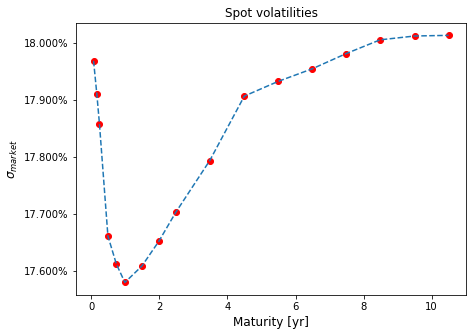

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(T,spot_vol,'--')
plt.scatter(T,spot_vol,c='red')
plt.ylabel("$\sigma_{market}$",fontsize=font)
plt.xlabel("Maturity [yr]",fontsize=font)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.title("Spot volatilities",fontsize=font)
#plt.savefig('Time_dep/spot_volatility.pdf',bbox_inches='tight')
plt.show()

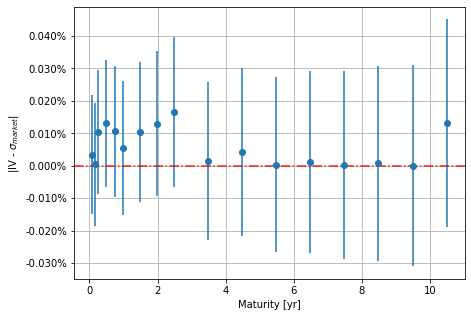

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
n_sigma = 1
plt.errorbar(T,abs(imp_volatility-spot_vol),yerr=[n_sigma*y_lower,n_sigma*y_upper], fmt = "o", label = "Monte Carlo")
plt.axhline(y=0, color = 'red',alpha = 0.9,linestyle='-.',label = 'Target')
plt.xlabel("Maturity [yr]")
plt.ylabel("|IV - $\sigma_{market}$|")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.grid(True)

plt.show()